# Neural Network Patient Matching

## Importing Dependencies

In [94]:
import chars2vec
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import itertools
# from gensim.models import Word2Vec
# from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine as cosine_distance

# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity



### changing the data rename numberrange to appointment date

In [47]:
df.rename(columns={'numberrange': 'appointmentdate'}, inplace=True)

In [48]:
df.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023


In [49]:
df.to_csv('Generated_Data.csv', index=False)

## Loading Data

In [2]:
# This Data was generated for generatedata.com
df=pd.read_csv('Generated_Data.csv')

In [3]:
df.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023


In [4]:
comparison_data=pd.read_csv('augmented_data_with_errors.csv')

In [5]:
comparison_data.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06


In [8]:
from nameparser import HumanName

# df = pd.DataFrame(data)
name_test=pd.DataFrame()
# Function to get first and last name using nameparser
def get_first_last_name(full_name):
    name = HumanName(full_name)
    return pd.Series([name.first, name.last])

# Apply the function to the names column and create new columns 'first_name' and 'last_name'
name_test[['first_name', 'last_name']] = df['name'].apply(get_first_last_name)

print(name_test)


   first_name last_name
0      Yvonne      Phua
1       Vance     Pawan
2        Lila    Chande
3       Signe      Shaw
4      Lucian   Lambert
..        ...       ...
95      Lance    Parker
96        Dai    Tucker
97    Tamekah     Joshi
98      Cyrus      Lata
99    Anthony     Mills

[100 rows x 2 columns]


## Glove Embedding the Names
<a id='Glove'></a>

### Embedding unique Patients records

In [9]:
# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

# Example: Load GloVe 50-dimensional vectors
glove_file = 'glove/glove.6B.50d.txt'  # Make sure this file is downloaded and accessible
embeddings_dict = load_glove_embeddings(glove_file)



In [10]:
# Function to get GloVe vector for a name
def get_glove_vector(name, embeddings_dict):
    words = name.split()
    vectors = [embeddings_dict[word.lower()] for word in words if word.lower() in embeddings_dict]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(50)  # Return a zero vector if no words are found in the embeddings

# Function to combine first name and last name embeddings
def combine_name_embeddings(first_name, last_name, embeddings_dict):
    first_name_vector = get_glove_vector(first_name, embeddings_dict) #getting vector for first name
    last_name_vector = get_glove_vector(last_name, embeddings_dict) #getting vector for last name
    combined_vector = np.concatenate((first_name_vector, last_name_vector)) #combining the both
    return combined_vector


In [11]:

# Apply the function to get combined GloVe vectors for the names
name_test['glove_vector'] = name_test.apply(lambda row: combine_name_embeddings(row['first_name'], row['last_name'], embeddings_dict), axis=1)

print(name_test)

   first_name last_name                                       glove_vector
0      Yvonne      Phua  [0.11147, -0.64607, -0.63477, 0.41512, 0.53992...
1       Vance     Pawan  [0.15975, -0.13687, 0.16425, 0.31973, -0.04463...
2        Lila    Chande  [0.095207, 0.42477, 0.094973, 0.33518, 0.36782...
3       Signe      Shaw  [-0.066854, 0.46045, -0.16831, -0.41079, 0.072...
4      Lucian   Lambert  [0.20914, 0.078152, -0.79982, -0.93575, -0.254...
..        ...       ...                                                ...
95      Lance    Parker  [-0.83642, 0.4444, -0.36313, 0.66111, 0.56587,...
96        Dai    Tucker  [-0.56747, 0.41503, -0.51142, 0.60125, 0.56971...
97    Tamekah     Joshi  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
98      Cyrus      Lata  [-0.20384, 0.47055, 0.2168, 0.36685, 0.023425,...
99    Anthony     Mills  [-0.33354, 0.85962, -0.22538, -0.35268, 0.8812...

[100 rows x 3 columns]


### Embedding 60k records

In [12]:
# Sample DataFrame
comb_df = comparison_data

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict



In [13]:
# Example: Load GloVe 50-dimensional vectors
glove_file = 'glove/glove.6B.50d.txt'
embeddings_dict = load_glove_embeddings(glove_file)

# Function to get GloVe vector for a name
def get_glove_vector(name, embeddings_dict):
    words = name.split()
    vectors = [embeddings_dict[word.lower()] for word in words if word.lower() in embeddings_dict]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(50)  # Return a zero vector if no words are found in the embeddings



In [14]:
# Extract first name and last name using nameparser
def extract_names(full_name):
    name = HumanName(full_name)
    first_name = name.first
    last_name = name.last
    return first_name, last_name



In [15]:
# Apply extraction and vectorization
comb_df['first_name'], comb_df['last_name'] = zip(*comb_df['name'].apply(extract_names))
comb_df['first_name_vector'] = comb_df['first_name'].apply(lambda name: get_glove_vector(name, embeddings_dict))
comb_df['last_name_vector'] = comb_df['last_name'].apply(lambda name: get_glove_vector(name, embeddings_dict))



In [16]:
# Combine first name and last name vectors
comb_df['combined_vector'] = comb_df.apply(lambda row: np.concatenate((row['first_name_vector'], row['last_name_vector'])), axis=1)

# Print the DataFrame
print(comb_df.head)


<bound method NDFrame.head of                 name           phone                    address  postalZip  \
0        Yvonne Phua  (833) 925-5254    Ap #437-2699 Sed Street      72001   
1        YvonnE Phua  (833) 925-5254    Ap #437-2699 Sed Street      72001   
2         Yvonne hua  (833) 925-5254    Ap #437-2699 Sed Street      72001   
3         Yvnne Phua  (833) 925-5254    Ap #437-2699 Sed Street      72001   
4        Yvonne Phau  (833) 925-5254    Ap #437-2699 Sed Street      72001   
...              ...             ...                        ...        ...   
59995  Anthony Malls  1-885-963-5745  Ap #544-242 Vulputate St.      76027   
59996  snthony Mills  1-885-963-5745  Ap #544-242 Vulputate St.      76027   
59997  Anthony Millr  1-885-963-5745  Ap #544-242 Vulputate St.      76027   
59998  nAthony Mills  1-885-963-5745  Ap #544-242 Vulputate St.      76027   
59999  AnthEny Mills  1-885-963-5745  Ap #544-242 Vulputate St.      76027   

      region appointmentdate firs

In [17]:
first_vector = name_test.iloc[1]['glove_vector']
print(first_vector)

[ 1.5975e-01 -1.3687e-01  1.6425e-01  3.1973e-01 -4.4635e-02  3.9757e-01
 -5.8394e-01 -5.2507e-03  2.5009e-01 -3.6931e-01 -9.7710e-03  1.1655e+00
 -8.7411e-01 -7.0349e-01  1.9039e-01  2.9796e-01  9.6015e-03  6.6729e-01
  2.7784e-01 -1.1252e-04 -2.2411e-01  4.8184e-01 -1.2842e-02 -3.9059e-01
  1.6188e-01 -1.2413e-01 -3.2754e-02 -3.1804e-01 -3.5555e-01  3.2356e-02
 -3.1424e-01 -7.4198e-01  7.6618e-02  1.5878e-01  9.7479e-01 -2.0361e-01
 -2.8319e-01 -3.6731e-01  4.7070e-01  2.7354e-01 -6.3218e-01  9.0989e-01
 -6.6736e-01 -1.0518e+00 -5.0956e-01  4.1419e-01  1.1161e-02 -1.1909e-01
 -1.1190e+00  9.4536e-01  1.0358e+00 -9.5743e-01  7.4951e-02  6.9496e-01
  7.8332e-02  8.8844e-01  7.1665e-01  3.3021e-01  1.6569e-01 -6.7502e-01
  3.6923e-01  6.7359e-01 -1.1695e+00  4.2132e-01  5.2439e-02 -8.0228e-02
  1.3319e+00  8.8379e-01  1.6342e-01 -2.3353e-01  1.4711e+00  2.6934e-01
 -7.9527e-02  5.4738e-01  1.0102e+00  7.9501e-01  1.1760e-01 -1.2289e-01
 -1.0682e+00  1.0003e-01 -8.4773e-01 -4.2972e-01  1

In [18]:
second_vector = comb_df.iloc[8]['combined_vector']
print(second_vector)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.05040002  0.50638998  0.1848      0.75326997
 -0.74757999 -0.019845   -0.002415    0.18305001 -1.08749998  0.15065999
 -0.092633    1.22189999 -0.23114     0.42386001 -0.002917    0.14740001
  0.86245     0.15821999  0.12638     1.00100005  0.005922   -0.30050001
  0.83043998  0.13431001  1.03030002  1.00629997  0.91254997  0.14985
 -1.29439998  0.23075999 -0.84182    -0.36414     1.62160003  0.30952001
 -0.28259999  0.036523   -0.52951998  0.53021

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

name_test['name'] = name_test['first_name'] + ' ' + name_test['last_name']

# Function to calculate cosine similarity between two vectors
def calculate_similarity(vec1, vec2):
    if vec1 is not None and vec2 is not None and np.linalg.norm(vec1) > 0 and np.linalg.norm(vec2) > 0:
        vec1 = vec1.reshape(1, -1)
        vec2 = vec2.reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    return -1  # Return a value indicating no similarity

# Example: Compare the first and second names in the DataFrame
first_vector = name_test.iloc[1]['glove_vector']
second_vector = comb_df.iloc[8]['combined_vector']
similarity = calculate_similarity(first_vector, second_vector)

print(f"Cosine similarity between '{name_test.iloc[1]['name']}' and '{comb_df.iloc[8]['name']}': {similarity}")


Cosine similarity between 'Vance Pawan' and 'Yvonnu Phua': 0.3229524002166211


## Glove Embedding similarity search

In [48]:
# Function to calculate cosine similarity between two vectors
def calculate_similarity(vec1, vec2):
    if vec1 is not None and vec2 is not None and np.linalg.norm(vec1) > 0 and np.linalg.norm(vec2) > 0:
        vec1 = vec1.reshape(1, -1)
        vec2 = vec2.reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    return -1  # Return a value indicating no similarity

# Find top 10 similar names for each name in name_test
results = []

for i, row in name_test.iterrows():
    first_vector = np.array(row['glove_vector'])
    similarities = {}
    for j, comb_row in comb_df.iterrows():
        second_vector = np.array(comb_row['combined_vector'])
        similarity = calculate_similarity(first_vector, second_vector)
        similarities[comb_row['name']] = similarity
    sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:10]
    results.append((f"{row['first_name']} {row['last_name']}", sorted_sim))




NameError: name 'name_test' is not defined

In [21]:
# Print results
for name, sim in results:
    print(f"Top similarities for '{name}':")
    for similar_name, similarity_score in sim:
        print(f"  {similar_name}: {similarity_score}")

Top similarities for 'Yvonne Phua':
  Yvonne Phua: 1.0000001192092896
  YvonnE Phua: 1.0000001192092896
  YVonne Phua: 1.0000001192092896
  YvOnne Phua: 1.0000001192092896
  Yvonne PhUa: 1.0000001192092896
  Yvonne PhuA: 1.0000001192092896
  YvonNe Phua: 1.0000001192092896
  Yvnne Phua: 0.7827694294117876
  Yvonfe Phua: 0.7827694294117876
  zvonne Phua: 0.7827694294117876
Top similarities for 'Vance Pawan':
  Vance Pawan: 1.0000001192092896
  Vance PAwan: 1.0000001192092896
  VAnce Pawan: 1.0000001192092896
  VancE Pawan: 1.0000001192092896
  Vance PawAn: 1.0000001192092896
  Hance Pawan: 0.8094372749328613
  hance Pawan: 0.8094372749328613
  Vnce Pawan: 0.7905522174031477
  Vacne Pawan: 0.7905522174031477
  VFnce Pawan: 0.7905522174031477
Top similarities for 'Lila Chande':
  Lila Chande: 0.9999998807907104
  Lila ChaNde: 0.9999998807907104
  Lila ChAnde: 0.9999998807907104
  Lila ChandE: 0.9999998807907104
  LilA Chande: 0.9999998807907104
  Lila ChanDe: 0.9999998807907104
  LIla Cha

In [22]:
test_name = "sai"
vector_test = get_glove_vector(test_name, embeddings_dict)
print(vector_test)

[ 0.57807  -0.17855  -0.27      0.42639  -0.51721  -1.4024    0.42906
 -1.7293    0.051245  0.21842  -0.28259   0.18621  -0.35479  -0.85801
 -0.66431   0.0565    0.28302   1.0565    0.50894   1.2317   -0.37974
  0.12995   0.035907  0.39744   0.65615  -0.028884  0.01102  -0.23933
 -1.5067   -0.58333   0.86866   0.39095  -0.088552  1.498     0.31116
 -0.052908 -0.14287   0.12936  -0.29448   0.8741   -0.34571   0.51985
 -0.90196  -0.056719  0.13456  -1.7353    0.35691  -0.82206   1.2585
  0.32251 ]


In [4]:
df = pd.read_csv('augmented_data_with_errors.csv')

In [7]:
df.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06


In [8]:
df.shape

(60000, 6)

## Char2Vec Model Test

In [3]:
# Models names: 'eng_50', 'eng_100', 'eng_150', 'eng_200', 'eng_300'
char2vec_model = chars2vec.load_model('eng_50')

In [4]:
comparison_data=pd.read_csv('augmented_data_with_errors.csv')

In [5]:
comparison_data.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06


In [6]:
# df.head()

In [7]:
# def string_to_char2vec(text, model):
#     vector_size = model.vector_size
#     text_vector = np.zeros(vector_size)
#     count = 0
#     for char in text:
#         if char in model:
#             text_vector += model[char]
#             count += 1
#     if count > 0:
#         text_vector /= count
#     return text_vector

def string_to_char2vec(text, model):
    words = text.split()
    word_embeddings = model.vectorize_words(words)
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # Adjust this based on the actual model
        


#### Sample Test char2vec

In [13]:
dd=[]
test_name='sai'
dd=string_to_char2vec(test_name,char2vec_model)

In [14]:
print(dd)

[ 0.2352183   0.18332934 -0.39466983 -0.39848813 -0.1963574  -0.42882484
 -0.34454745 -0.15425043  0.10691694  0.2954886   0.15222652  0.2396302
 -0.03185706 -0.2742316  -0.03778273  0.10523014  0.3349534   0.04406559
  0.32868838 -0.27972546 -0.31272924 -0.12171837  0.16993324 -0.0698605
 -0.45560673  0.18869801 -0.54178226 -0.12062541  0.01480137 -0.09028091
  0.2750435  -0.4611004  -0.1523074  -0.40607873  0.31060347 -0.13316493
  0.1070827  -0.1653917   0.21500456  0.09355868 -0.19680081 -0.41275004
 -0.36387292 -0.25216976 -0.26877335  0.43172807  0.04806376  0.23162043
  0.26437977  0.5339936 ]


In [15]:
transformed_data = {}


columns_to_transform = ['name', 'phone', 'address', 'postalZip', 'region', 'appointmentdate']



In [16]:
# columns_to_transform = ['name', 'phone', 'address', 'postalZip', 'region', 'appointmentdate']

# # Apply the string_to_char2vec function to each column and store the result in test_df
# for column in columns_to_transform:
#     dd[column + '_vector'] = comparison_data[column].apply(lambda x: string_to_char2vec(x, char2vec_model))




# Apply the string_to_char2vec function to the first record of each column and store the result in transformed_data
for column in columns_to_transform:
    first_record = str(comparison_data[column].iloc[0])  # Convert the first record to string
    transformed_data[column + '_vector'] = [string_to_char2vec(first_record, char2vec_model)]

# Convert the dictionary to a DataFrame
test_df = pd.DataFrame(transformed_data)

In [17]:
print(test_df)

                                         name_vector  \
0  [-0.028295435, 0.061307847, -0.28801212, -0.03...   

                                        phone_vector  \
0  [-0.086652465, -0.20205903, -0.35300657, -0.09...   

                                      address_vector  \
0  [-0.067042634, -0.10889009, -0.22971782, -0.35...   

                                    postalZip_vector  \
0  [0.15365833, -0.0151055725, -0.1472025, 0.0782...   

                                       region_vector  \
0  [0.09799966, 0.20050512, -0.3300184, 0.2884834...   

                              appointmentdate_vector  
0  [-0.11671179, -0.4093179, -0.6979892, -0.04990...  


In [13]:
# transformed_data = pd.DataFrame()
transformed_data.loc[:, :] = None

### Char2vec Generating
<a id='chars2vecgen'></a>

In [14]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

In [15]:
transformed_data = pd.DataFrame(index=comparison_data.index)
for column in comparison_data.columns:
    transformed_data[column + '_vector'] = pd.Series([None]*len(comparison_data), dtype=object)

columns_to_transform = ['name', 'phone', 'address', 'postalZip', 'region', 'appointmentdate']


In [16]:
chunk_size = 1000

In [17]:
def process_chunk(start, end):
    for index in range(start, end):
        for column in columns_to_transform:
            field_value = str(comparison_data.at[index, column])
            vector = string_to_char2vec(field_value, char2vec_model)
            transformed_data.at[index, column + '_vector'] = vector.tolist()

num_records = len(comparison_data)
for start in range(0, num_records, chunk_size):
    end = min(start + chunk_size, num_records)
    process_chunk(start, end)
    if start % (chunk_size * 10) == 0:  # Print progress every 10 chunks
        print(f"Processed records {start} to {end}")

print("Processing complete.")

Processed records 0 to 1000
Processed records 10000 to 11000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [18]:
transformed_data.shape

(60000, 6)

In [19]:
transformed_data.head()

,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector
0,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
1,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
2,"[-0.026903733611106873, 0.05541733652353287, -...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0..."
3,"[-0.02815631777048111, 0.12980066239833832, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0..."
4,"[0.0011936575174331665, 0.033218637108802795, ...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[0.06658968329429626, 0.05025216192007065, -0...."


In [21]:
comparison_data.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06


In [22]:
combined_df = pd.concat([comparison_data, transformed_data], axis=1)

In [23]:
combined_df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.026903733611106873, 0.05541733652353287, -...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0..."
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.02815631777048111, 0.12980066239833832, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0..."
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06,"[0.0011936575174331665, 0.033218637108802795, ...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[0.06658968329429626, 0.05025216192007065, -0...."


In [24]:
combined_df.to_csv('char2vec_60k.csv', index=False)

In [ ]:
cc_df= pd.read_csv('100K_vector_data.csv')

In [35]:
df=pd.read_csv('100K_vector_Data.csv')

### Char2vec Stacking the vectors

In [142]:
# Stack vectors function
def stack_vectors(row, vector_columns, target_length=None):
    vectors = []
    for col in vector_columns:
        vector = row[col]
        if target_length is not None:
            # Ensure the vector is the target length by padding or truncating
            if len(vector) < target_length:
                vector = np.pad(vector, (0, target_length - len(vector)), mode='constant')
            else:
                vector = vector[:target_length]
        vectors.append(vector)
    return np.hstack(vectors)

# Apply stacking function
df['stacked_vector'] = df.apply(stack_vectors, axis=1, vector_columns=vector_columns)

# # Inspect DataFrame before saving
# print("DataFrame before saving to CSV:")
# print(df)

# # Serialize the vectors to strings explicitly
# df['stacked_vector'] = df['stacked_vector'].apply(lambda x: ','.join(map(str, x)))

# # Inspect DataFrame after converting vectors to strings
# print("\nDataFrame after converting vectors to strings:")
# print(df)

# # Save to CSV
# df.to_csv('char2vec_stacked_100.csv', index=False)

# # Reload the CSV to verify the content
# reloaded_df = pd.read_csv('char2vec_stacked_100.csv')

# print("\nReloaded DataFrame from CSV:")
# print(reloaded_df)

#### Stacking 60k Vector data

In [104]:
cc_df=pd.read_csv('char2vec_60k.csv')

In [105]:
cc_df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.026903733611106873, 0.05541733652353287, -...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0..."
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.02815631777048111, 0.12980066239833832, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0..."
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06,"[0.0011936575174331665, 0.033218637108802795, ...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[0.06658968329429626, 0.05025216192007065, -0...."


In [106]:
vector_columns = [col for col in cc_df.columns if col.endswith('_vector')]

In [32]:
# print(vector_columns) #To Check the columns identified.

In [64]:
# def stack_vectors(row):
#     vectors = [row[col] for col in vector_columns]
#     return np.hstack(vectors)


In [107]:

# Apply the function to each row and store the result in a new column
cc_df['stacked_vector'] = cc_df.apply(stack_vectors, axis=1, vector_columns=vector_columns)


In [108]:
cc_df['stacked_vector'] = cc_df['stacked_vector'].apply(lambda x: ','.join(map(str, x)))


In [109]:
cc_df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.026903733611106873, 0.05541733652353287, -...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0...","[-0.026903733611106873, 0.05541733652353287, -..."
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.02815631777048111, 0.12980066239833832, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0...","[-0.02815631777048111, 0.12980066239833832, -0..."
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06,"[0.0011936575174331665, 0.033218637108802795, ...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[0.06658968329429626, 0.05025216192007065, -0....","[0.0011936575174331665, 0.033218637108802795, ..."


In [110]:
cc_df.to_csv('char2vec_stacked_60k.csv', index=False)

In [111]:
cc_df=pd.read_csv('char2vec_stacked_60k.csv')

In [112]:
cc_df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.026903733611106873, 0.05541733652353287, -...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0...","[-0.026903733611106873, 0.05541733652353287, -..."
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.02815631777048111, 0.12980066239833832, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0...","[-0.02815631777048111, 0.12980066239833832, -0..."
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06,"[0.0011936575174331665, 0.033218637108802795, ...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[0.06658968329429626, 0.05025216192007065, -0....","[0.0011936575174331665, 0.033218637108802795, ..."


#### Stacking unique patients records

In [42]:
# for col in vector_columns:
#     df[col] = df[col].apply(lambda x: np.array(eval(x)))

In [38]:
df=pd.read_csv('100_vector_Data.csv')

In [39]:
df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -..."
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024,"[0.1911291480064392, 0.024142228066921234, -0....","[-0.012659147381782532, -0.1496986299753189, -...","[-0.05556339770555496, -0.0822235643863678, -0...","[0.046740349382162094, -0.23008249700069427, -...","[0.21812616288661957, 0.2737581729888916, -0.7...","[0.007002758327871561, -0.221664696931839, -0...."
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023,"[0.08759836107492447, 0.2639116048812866, -0.4...","[0.008137657307088375, -0.14661380648612976, -...","[-0.009406909346580505, -0.11577487736940384, ...","[-0.0025370812509208918, 0.010805221274495125,...","[0.057486291974782944, -0.7500688433647156, -0...","[-0.1258363574743271, -0.2795145511627197, -0...."
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023,"[0.26325342059135437, 0.2579621970653534, -0.4...","[0.1516619324684143, -0.2979848086833954, 0.30...","[-0.10623608529567719, -0.1663561761379242, -0...","[0.08315715193748474, -0.10057041794061661, -0...","[0.06826953589916229, -0.22756607830524445, -0...","[-0.1440032422542572, -0.38456642627716064, -0..."
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023,"[0.07604440301656723, -0.16849592328071594, -0...","[-0.2241271287202835, -0.6125736832618713, -0....","[-0.20521825551986694, -0.1208835244178772, -0...","[0.14711114764213562, -0.06145806238055229, -0...","[-0.6520544290542603, -0.8191417455673218, -0....","[-0.0983523353934288, -0.3623514473438263, -0...."


In [40]:
vector_columns = [col for col in df.columns if col.endswith('_vector')]

In [43]:
df['stacked_vector'] = df.apply(stack_vectors, axis=1)

In [44]:
df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[[-0.02829543501138687, 0.06130784749984741, -..."
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024,"[0.1911291480064392, 0.024142228066921234, -0....","[-0.012659147381782532, -0.1496986299753189, -...","[-0.05556339770555496, -0.0822235643863678, -0...","[0.046740349382162094, -0.23008249700069427, -...","[0.21812616288661957, 0.2737581729888916, -0.7...","[0.007002758327871561, -0.221664696931839, -0....","[[0.1911291480064392, 0.024142228066921234, -0..."
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023,"[0.08759836107492447, 0.2639116048812866, -0.4...","[0.008137657307088375, -0.14661380648612976, -...","[-0.009406909346580505, -0.11577487736940384, ...","[-0.0025370812509208918, 0.010805221274495125,...","[0.057486291974782944, -0.7500688433647156, -0...","[-0.1258363574743271, -0.2795145511627197, -0....","[[0.08759836107492447, 0.2639116048812866, -0...."
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023,"[0.26325342059135437, 0.2579621970653534, -0.4...","[0.1516619324684143, -0.2979848086833954, 0.30...","[-0.10623608529567719, -0.1663561761379242, -0...","[0.08315715193748474, -0.10057041794061661, -0...","[0.06826953589916229, -0.22756607830524445, -0...","[-0.1440032422542572, -0.38456642627716064, -0...","[[0.26325342059135437, 0.2579621970653534, -0...."
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023,"[0.07604440301656723, -0.16849592328071594, -0...","[-0.2241271287202835, -0.6125736832618713, -0....","[-0.20521825551986694, -0.1208835244178772, -0...","[0.14711114764213562, -0.06145806238055229, -0...","[-0.6520544290542603, -0.8191417455673218, -0....","[-0.0983523353934288, -0.3623514473438263, -0....","[[0.07604440301656723, -0.16849592328071594, -..."


In [45]:
df.to_csv('char2vec_stacked_100.csv', index=False)

#### Issue Persist

In [61]:
#### Checking the .csv
df=pd.read_csv('char2vec_stacked_100.csv')

In [62]:
df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","['[-0.02829543501138687, 0.06130784749984741, ..."
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024,"[0.1911291480064392, 0.024142228066921234, -0....","[-0.012659147381782532, -0.1496986299753189, -...","[-0.05556339770555496, -0.0822235643863678, -0...","[0.046740349382162094, -0.23008249700069427, -...","[0.21812616288661957, 0.2737581729888916, -0.7...","[0.007002758327871561, -0.221664696931839, -0....","['[0.1911291480064392, 0.024142228066921234, -..."
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023,"[0.08759836107492447, 0.2639116048812866, -0.4...","[0.008137657307088375, -0.14661380648612976, -...","[-0.009406909346580505, -0.11577487736940384, ...","[-0.0025370812509208918, 0.010805221274495125,...","[0.057486291974782944, -0.7500688433647156, -0...","[-0.1258363574743271, -0.2795145511627197, -0....","['[0.08759836107492447, 0.2639116048812866, -0..."
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023,"[0.26325342059135437, 0.2579621970653534, -0.4...","[0.1516619324684143, -0.2979848086833954, 0.30...","[-0.10623608529567719, -0.1663561761379242, -0...","[0.08315715193748474, -0.10057041794061661, -0...","[0.06826953589916229, -0.22756607830524445, -0...","[-0.1440032422542572, -0.38456642627716064, -0...","['[0.26325342059135437, 0.2579621970653534, -0..."
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023,"[0.07604440301656723, -0.16849592328071594, -0...","[-0.2241271287202835, -0.6125736832618713, -0....","[-0.20521825551986694, -0.1208835244178772, -0...","[0.14711114764213562, -0.06145806238055229, -0...","[-0.6520544290542603, -0.8191417455673218, -0....","[-0.0983523353934288, -0.3623514473438263, -0....","['[0.07604440301656723, -0.16849592328071594, ..."


In [77]:
vector_columns = [col for col in df.columns if col.endswith('_vector')]

In [66]:
df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[[-0.02829543501138687, 0.06130784749984741, -..."
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024,"[0.1911291480064392, 0.024142228066921234, -0....","[-0.012659147381782532, -0.1496986299753189, -...","[-0.05556339770555496, -0.0822235643863678, -0...","[0.046740349382162094, -0.23008249700069427, -...","[0.21812616288661957, 0.2737581729888916, -0.7...","[0.007002758327871561, -0.221664696931839, -0....","[[0.1911291480064392, 0.024142228066921234, -0..."
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023,"[0.08759836107492447, 0.2639116048812866, -0.4...","[0.008137657307088375, -0.14661380648612976, -...","[-0.009406909346580505, -0.11577487736940384, ...","[-0.0025370812509208918, 0.010805221274495125,...","[0.057486291974782944, -0.7500688433647156, -0...","[-0.1258363574743271, -0.2795145511627197, -0....","[[0.08759836107492447, 0.2639116048812866, -0...."
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023,"[0.26325342059135437, 0.2579621970653534, -0.4...","[0.1516619324684143, -0.2979848086833954, 0.30...","[-0.10623608529567719, -0.1663561761379242, -0...","[0.08315715193748474, -0.10057041794061661, -0...","[0.06826953589916229, -0.22756607830524445, -0...","[-0.1440032422542572, -0.38456642627716064, -0...","[[0.26325342059135437, 0.2579621970653534, -0...."
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023,"[0.07604440301656723, -0.16849592328071594, -0...","[-0.2241271287202835, -0.6125736832618713, -0....","[-0.20521825551986694, -0.1208835244178772, -0...","[0.14711114764213562, -0.06145806238055229, -0...","[-0.6520544290542603, -0.8191417455673218, -0....","[-0.0983523353934288, -0.3623514473438263, -0....","[[0.07604440301656723, -0.16849592328071594, -..."


In [68]:
df.to_csv('char2vec_stacked_100.csv', index=False)

In [97]:
df=pd.read_csv('char2vec_stacked_100.csv')

In [98]:
df.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024,"[0.1911291480064392, 0.024142228066921234, -0....","[-0.012659147381782532, -0.1496986299753189, -...","[-0.05556339770555496, -0.0822235643863678, -0...","[0.046740349382162094, -0.23008249700069427, -...","[0.21812616288661957, 0.2737581729888916, -0.7...","[0.007002758327871561, -0.221664696931839, -0....","[0.1911291480064392, 0.024142228066921234, -0...."
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023,"[0.08759836107492447, 0.2639116048812866, -0.4...","[0.008137657307088375, -0.14661380648612976, -...","[-0.009406909346580505, -0.11577487736940384, ...","[-0.0025370812509208918, 0.010805221274495125,...","[0.057486291974782944, -0.7500688433647156, -0...","[-0.1258363574743271, -0.2795145511627197, -0....","[0.08759836107492447, 0.2639116048812866, -0.4..."
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023,"[0.26325342059135437, 0.2579621970653534, -0.4...","[0.1516619324684143, -0.2979848086833954, 0.30...","[-0.10623608529567719, -0.1663561761379242, -0...","[0.08315715193748474, -0.10057041794061661, -0...","[0.06826953589916229, -0.22756607830524445, -0...","[-0.1440032422542572, -0.38456642627716064, -0...","[0.26325342059135437, 0.2579621970653534, -0.4..."
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023,"[0.07604440301656723, -0.16849592328071594, -0...","[-0.2241271287202835, -0.6125736832618713, -0....","[-0.20521825551986694, -0.1208835244178772, -0...","[0.14711114764213562, -0.06145806238055229, -0...","[-0.6520544290542603, -0.8191417455673218, -0....","[-0.0983523353934288, -0.3623514473438263, -0....","[0.07604440301656723, -0.16849592328071594, -0..."


## Similarity test (TEST)

In [127]:
# Load the Datasets
df_100 = pd.read_csv('char2vec_stacked_100.csv')
df_60k = pd.read_csv('char2vec_stacked_60K.csv')

In [128]:
df_100.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024,"[0.1911291480064392, 0.024142228066921234, -0....","[-0.012659147381782532, -0.1496986299753189, -...","[-0.05556339770555496, -0.0822235643863678, -0...","[0.046740349382162094, -0.23008249700069427, -...","[0.21812616288661957, 0.2737581729888916, -0.7...","[0.007002758327871561, -0.221664696931839, -0....","[0.1911291480064392, 0.024142228066921234, -0...."
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023,"[0.08759836107492447, 0.2639116048812866, -0.4...","[0.008137657307088375, -0.14661380648612976, -...","[-0.009406909346580505, -0.11577487736940384, ...","[-0.0025370812509208918, 0.010805221274495125,...","[0.057486291974782944, -0.7500688433647156, -0...","[-0.1258363574743271, -0.2795145511627197, -0....","[0.08759836107492447, 0.2639116048812866, -0.4..."
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023,"[0.26325342059135437, 0.2579621970653534, -0.4...","[0.1516619324684143, -0.2979848086833954, 0.30...","[-0.10623608529567719, -0.1663561761379242, -0...","[0.08315715193748474, -0.10057041794061661, -0...","[0.06826953589916229, -0.22756607830524445, -0...","[-0.1440032422542572, -0.38456642627716064, -0...","[0.26325342059135437, 0.2579621970653534, -0.4..."
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023,"[0.07604440301656723, -0.16849592328071594, -0...","[-0.2241271287202835, -0.6125736832618713, -0....","[-0.20521825551986694, -0.1208835244178772, -0...","[0.14711114764213562, -0.06145806238055229, -0...","[-0.6520544290542603, -0.8191417455673218, -0....","[-0.0983523353934288, -0.3623514473438263, -0....","[0.07604440301656723, -0.16849592328071594, -0..."


In [129]:
df_60k.head()

,name,phone,address,postalZip,region,appointmentdate,name_vector,phone_vector,address_vector,postalZip_vector,region_vector,appointmentdate_vector,stacked_vector
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023,"[-0.02829543501138687, 0.06130784749984741, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.11671178787946701, -0.40931791067123413, -...","[-0.02829543501138687, 0.06130784749984741, -0..."
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.026903733611106873, 0.05541733652353287, -...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0...","[-0.026903733611106873, 0.05541733652353287, -..."
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023,"[-0.02815631777048111, 0.12980066239833832, -0...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[-0.10825420171022415, -0.3191474676132202, -0...","[-0.02815631777048111, 0.12980066239833832, -0..."
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06,"[0.0011936575174331665, 0.033218637108802795, ...","[-0.08665246516466141, -0.20205903053283691, -...","[-0.06704263389110565, -0.10889008641242981, -...","[0.15365833044052124, -0.015105572529137135, -...","[0.09799966216087341, 0.2005051225423813, -0.3...","[0.06658968329429626, 0.05025216192007065, -0....","[0.0011936575174331665, 0.033218637108802795, ..."


In [140]:
df_60k['stacked_vector'].head()

0    [-0.02829543501138687, 0.06130784749984741, -0...
1    [-0.02829543501138687, 0.06130784749984741, -0...
2    [-0.026903733611106873, 0.05541733652353287, -...
3    [-0.02815631777048111, 0.12980066239833832, -0...
4    [0.0011936575174331665, 0.033218637108802795, ...
Name: stacked_vector, dtype: object

In [141]:
df_100['stacked_vector'].head()

0    [-0.02829543501138687, 0.06130784749984741, -0...
1    [0.1911291480064392, 0.024142228066921234, -0....
2    [0.08759836107492447, 0.2639116048812866, -0.4...
3    [0.26325342059135437, 0.2579621970653534, -0.4...
4    [0.07604440301656723, -0.16849592328071594, -0...
Name: stacked_vector, dtype: object

In [131]:
def find_top_similar_vectors(target_vector, all_vectors, top_n=10):
    """
    Find the top N most similar vectors to the target_vector using cosine similarity.

    Parameters:
    - target_vector: A 1D numpy array representing the target vector.
    - all_vectors: A 2D numpy array where each row is a vector to compare against.
    - top_n: The number of most similar vectors to return.

    Returns:
    - indices of the top N most similar vectors.
    - similarities of the top N most similar vectors.
    """
    # Compute cosine similarities
    similarities = cosine_similarity([target_vector], all_vectors)[0]
    
    # Get the indices of the top N most similar vectors
    top_n_indices = np.argsort(similarities)[-top_n:][::-1]
    
    # Get the similarities of the top N most similar vectors
    top_n_similarities = similarities[top_n_indices]
    
    return top_n_indices, top_n_similarities


In [143]:
# # Convert 'stacked_vector' columns from string to lists
# df_100['stacked_vector'] = df_100['stacked_vector'].apply(lambda x: np.array(ast.literal_eval(x)))
# df_60k['stacked_vector'] = df_60k['stacked_vector'].apply(lambda x: np.array(ast.literal_eval(x)))

# Convert 'stacked_vector' columns from string to object arrays
df_100['stacked_vector'] = df_100['stacked_vector'].apply(lambda x: np.array(ast.literal_eval(x), dtype=object))
df_60k['stacked_vector'] = df_60k['stacked_vector'].apply(lambda x: np.array(ast.literal_eval(x), dtype=object))

In [147]:
# Convert 'stacked_vector' columns from string to properly formatted NumPy arrays
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except:
        return None

def convert_to_numpy_array(val):
    array = safe_literal_eval(val)
    if array is not None:
        return np.array(array)
    return None

df_100['stacked_vector'] = df_100['stacked_vector'].apply(convert_to_numpy_array)
df_60k['stacked_vector'] = df_60k['stacked_vector'].apply(convert_to_numpy_array)

In [149]:
# Function to calculate cosine similarity between two vectors
def calculate_similarity(vec1, vec2):
    if vec1 is not None and vec2 is not None and np.linalg.norm(vec1) > 0 and np.linalg.norm(vec2) > 0:
        vec1 = vec1.reshape(1, -1)
        vec2 = vec2.reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    return -1  # Return a value indicating no similarity

# Find top 10 similar vectors for each vector in df_100
results = []

for i, row in df_100.iterrows():
    first_vector = row['stacked_vector']
    similarities = {}
    for j, comb_row in df_60k.iterrows():
        second_vector = comb_row['stacked_vector']
        similarity = calculate_similarity(first_vector, second_vector)
        similarities[j] = similarity  # Using index as the key
    sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:10]
    results.append((i, sorted_sim))  # Using index as the identifier

# Print results
for index, sim in results:
    print(f"Top similarities for index {index} in df_100:")
    for similar_index, similarity_score in sim:
        print(f"  Index {similar_index} in df_60k: {similarity_score}")

Top similarities for index 0 in df_100:
  Index 0 in df_60k: -1
  Index 1 in df_60k: -1
  Index 2 in df_60k: -1
  Index 3 in df_60k: -1
  Index 4 in df_60k: -1
  Index 5 in df_60k: -1
  Index 6 in df_60k: -1
  Index 7 in df_60k: -1
  Index 8 in df_60k: -1
  Index 9 in df_60k: -1
Top similarities for index 1 in df_100:
  Index 0 in df_60k: -1
  Index 1 in df_60k: -1
  Index 2 in df_60k: -1
  Index 3 in df_60k: -1
  Index 4 in df_60k: -1
  Index 5 in df_60k: -1
  Index 6 in df_60k: -1
  Index 7 in df_60k: -1
  Index 8 in df_60k: -1
  Index 9 in df_60k: -1
Top similarities for index 2 in df_100:
  Index 0 in df_60k: -1
  Index 1 in df_60k: -1
  Index 2 in df_60k: -1
  Index 3 in df_60k: -1
  Index 4 in df_60k: -1
  Index 5 in df_60k: -1
  Index 6 in df_60k: -1
  Index 7 in df_60k: -1
  Index 8 in df_60k: -1
  Index 9 in df_60k: -1
Top similarities for index 3 in df_100:
  Index 0 in df_60k: -1
  Index 1 in df_60k: -1
  Index 2 in df_60k: -1
  Index 3 in df_60k: -1
  Index 4 in df_60k: -1


## Descriptive Analysis

In [24]:
# 1. Descriptive Statistics
def descriptive_statistics(df):
    print("Descriptive Statistics:")
    print(df.describe())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nData Types:\n", df.dtypes)



In [25]:
# 2. Data Visualization

# Univariate Analysis
def univariate_analysis(df, column):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histogram of {column}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column].dropna())
    plt.title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()

# Bivariate Analysis
def bivariate_analysis(df, x, y):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df[x], y=df[y])
    plt.title(f'Scatter plot between {x} and {y}')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=df[x], y=df[y])
    plt.title(f'Line plot of {x} vs {y}')

    plt.tight_layout()
    plt.show()



In [26]:
# 3. Correlation Analysis
# def correlation_analysis(df):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
#     plt.title('Correlation Heatmap')
#     plt.show()

In [27]:
def correlation_analysis(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns to compute correlation.")
        return

    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=False, yticklabels=False)
    plt.title('Correlation Heatmap')
    plt.show()

# 4. Handling Missing Values
def missing_value_analysis(df):
    print("\nMissing Value Analysis:")
    print(df.isnull().sum())
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

Descriptive Statistics:
          postalZip
count    100.000000
mean   54282.300000
std    23495.002194
min    12575.000000
25%    33455.250000
50%    55006.500000
75%    73365.000000
max    99811.000000

Missing Values:
 name           0
phone          0
address        0
postalZip      0
region         0
numberrange    0
dtype: int64

Data Types:
 name           object
phone          object
address        object
postalZip       int64
region         object
numberrange    object
dtype: object


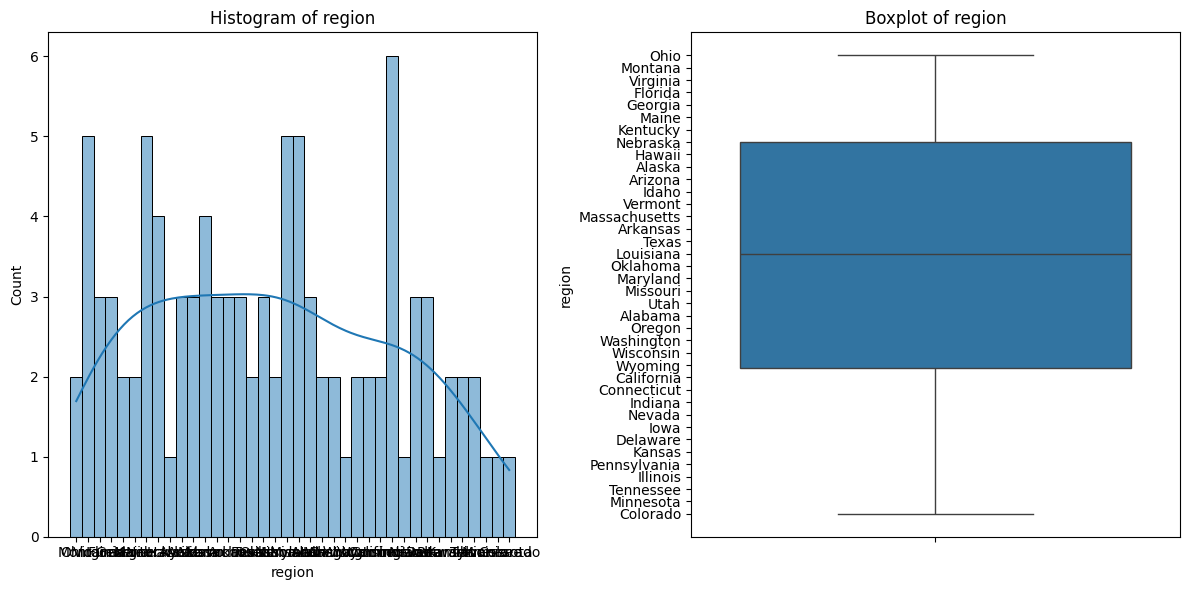

In [28]:
descriptive_statistics(df)
univariate_analysis(df, 'region')

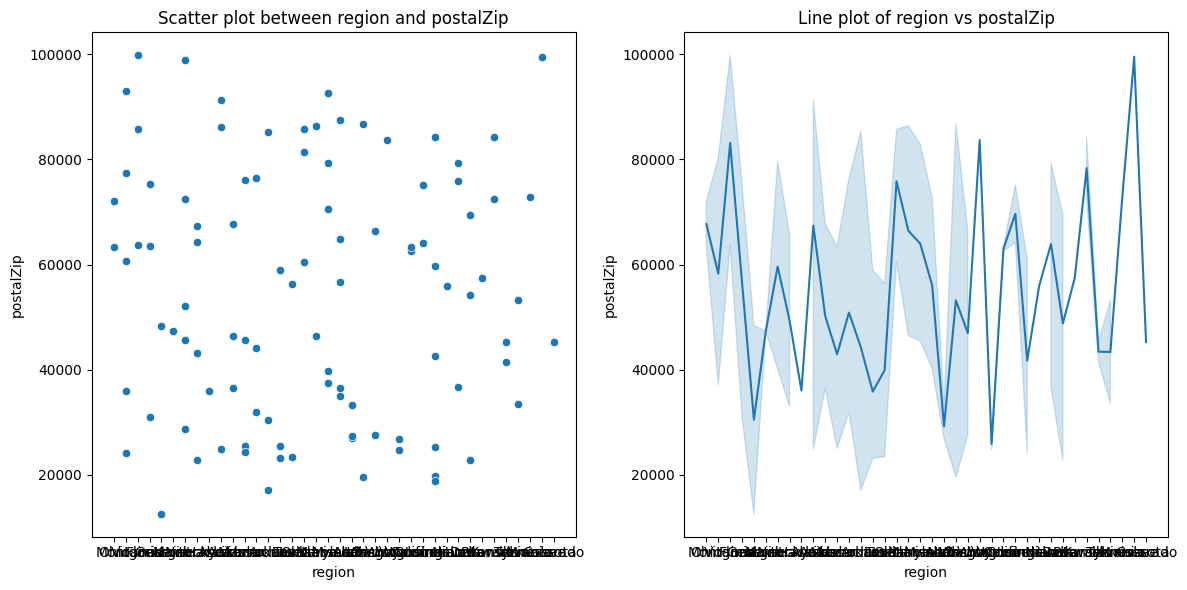

In [29]:
bivariate_analysis(df, 'region', 'postalZip')

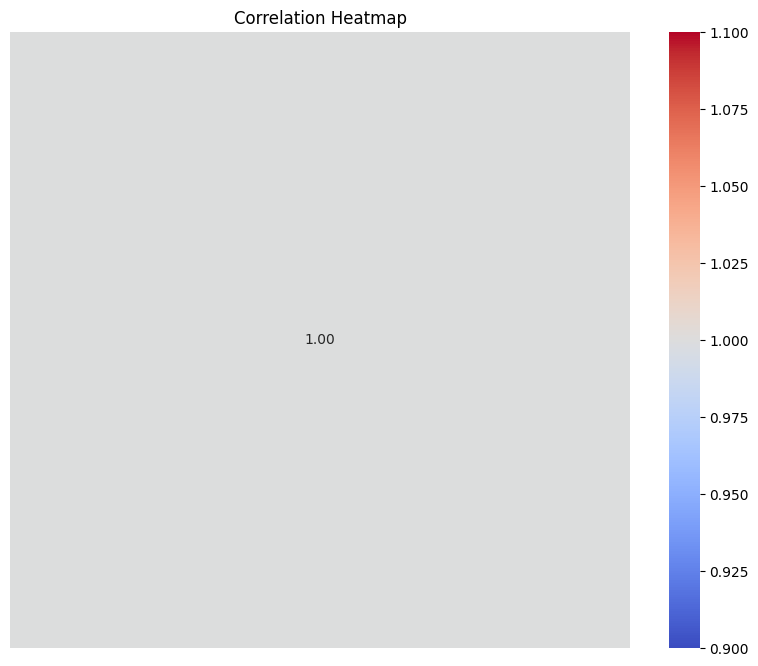

In [30]:
correlation_analysis(df)


Missing Value Analysis:
name           0
phone          0
address        0
postalZip      0
region         0
numberrange    0
dtype: int64


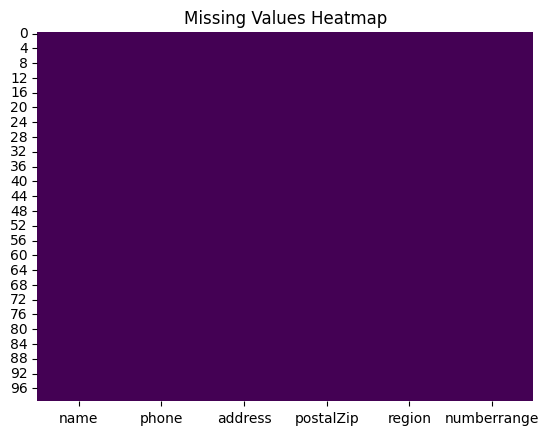

In [31]:
missing_value_analysis(df)